# Pairs-Trading (Negative / Low Correlation) Strategy Analysis

The negative/low correlation pairs trading strategy involves taking advantage of the performance divergence between two loosely correlated or negatively correlated assets by longing the stronger asset and shorting the weaker one. Here's how it works:

- **Identifying a Pair**: Choose two assets with a negative or low correlation. These assets should exhibit enough volatility and liquidity to make the strategy feasible. One way is to identify tokens subject to significant upcoming unlocks or emissions. These events often lead to a downward price trend due to the anticipation of selling pressure from early investors or insiders. Thus, they are generally weaker. Then, pair the selected token (likely to experience downward pressure) with a stronger token that has a robust narrative and positive momentum. The stronger token should be in a different sector or have a different utility to ensure diversification.
- **Establishing the Historical Relationship**: Analyze historical price data to understand the typical performance relationship between the two assets. Use statistical measures like the correlation coefficient to confirm their relationship. Research the history of similar tokens and their price movements around unlock/emission events. This helps in predicting potential downward trends.
- **Executing Trades**: When Asset A (stronger asset) significantly outperforms Asset B (weaker asset), go long on Asset A and short on Asset B. The idea is that the stronger asset will continue to outperform the weaker one in the short to medium term.
- **Monitoring and Adjusting**: Continuously monitor the performance of both assets and the overall market conditions. Adjust positions as necessary to manage risk and maximize returns.

In this notebook, the pair trading negative / low correlation strategy is demonstrated using cryptocurrency price data sourced from the Binance, OKX, and Bybit APIs.

## Prepare your Environment

Ensure that the 'venv' kernel is selected for this notebook. If not, click on 'Kernel' at the top bar, select 'Change Kernel...' and select 'venv' as the kernel. For convenience, ensure that 'Always start the preferred kernel' is ticked. Click 'Select' to confirm the setting.

Install the environment's dependencies using the command below. After installation, restart the kernel to use the updated packages. To restart, click on 'Kernel' at the top bar and select 'Restart Kernel' and click on 'Restart'. Please skip this step if you have already done it.

In [3]:
pip install -r requirements.txt

You should consider upgrading via the '/Users/gordon.oh/Desktop/quant_research/venv/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Import packages

In [37]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import sys
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import coint
from itertools import combinations
from statsmodels.tsa.stattools import coint
from utils import calculate_profit, plot_strategy
from data_manager import load_ts_df, process_data, sanitize_data

## Process Price Dataframe

- Before proceeding, ensure that the price data has been downloaded using ***'data_manager.py'***.
- Enter the ***cex*** (Centralized Exchange) and ***interval*** values used for data download to load the relevant *.pkl* files and retrieve the dataframe.
- You can specify a batch of pairs to load using the ***selected_pairs*** variable. If no pairs are selected, all available pairs will be loaded by default.
- Note that some pairs might be new and may lack sufficient data within the downloaded timeframe. Such pairs will be removed based on the ***nan_remove_threshold*** setting, which defines the maximum percentage of NaN values allowed relative to the total data points. For example, with a ***nan_remove_threshold*** of 0.1, if a pair has 100 data points and 15 are NaN, the pair will be excluded.
- From the remaining pairs, you can filter the top N volume pairs using the ***top_n_volume_pairs*** parameter.
- This part of the code will also ensure that all timeseries columns have the same number of data points.
- The earliest and latest dates for all pairs will be recorded. These dates can then be used to determine the timeframe for slicing the data in the next step.

### Inputs

In [38]:
##### INPUTS #####
cex = 'binance'
interval = '4h'
nan_remove_threshold = 0.1

# Select only the pairs below to analyse. All pairs will be selected if the list is empty.
selected_pairs = []

# Select only the top N mean volume pairs from the selected pairs to analyse.
top_n_volume_pairs = 100

# Select volume filter mode. Options: ['rolling', 'mean'].
volume_filter_mode = 'rolling'
##################

In [39]:
print("\nMode: Pairs-Trading (Negative / Low Correlation) Strategy")
print("CEX: {}".format(str(cex).capitalize()))
print("Interval: {}".format(interval))
print("NaN Remove Threshold: {}".format(nan_remove_threshold))
print("Selected pairs to analyse: {}".format(selected_pairs))
print("Top N Volume Pairs: {}".format(top_n_volume_pairs))
print("Volume Filter Mode: {}".format(str(volume_filter_mode).capitalize()))

merged_df = process_data('low_correlation', cex, interval, nan_remove_threshold, selected_pairs,
                 top_n_volume_pairs, volume_filter_mode)

print("\n")


Mode: Pairs-Trading (Negative / Low Correlation) Strategy
CEX: Binance
Interval: 4h
NaN Remove Threshold: 0.1
Selected pairs to analyse: []
Top N Volume Pairs: 100
Volume Filter Mode: Rolling

Columns that contains NaN values:
         Pair  NaN Count          Remark
0     ZROUSDT        524       To Remove
11  LISTAUSDT        524       To Remove
3     MEWUSDT        506       To Remove
9      ZKUSDT        505       To Remove
7      IOUSDT        470       To Remove
13  TURBOUSDT        398       To Remove
12    NOTUSDT        314       To Remove
6      BBUSDT        296       To Remove
2     REZUSDT        218       To Remove
5    OMNIUSDT        140       To Remove
10    TAOUSDT        104       To Remove
1    SAGAUSDT         91       To Remove
4    TNSRUSDT         87       To Remove
14      WUSDT         56  To Interpolate
8     ENAUSDT         50  To Interpolate

Removed 13 pairs as they contain too many NaN values.

Filtered top 100 mean volume pairs.
Successfully loaded cand

## Sanitize the dataframe

- Slice the dataframe according to the specified ***start_date*** and ***end_date***. Choose ***start_date*** and ***end_date*** within the timeframe shown by the output of the previous cell.
- Interpolate any missing values in the dataframe.
- If the interpolation fails, just backfill with the latest valid value.
- Verify that all is as expected with an `assert` and check the shapes of 2 random pairs, which should have the same dimensions.

### Inputs

In [40]:
##### INPUTS #####
start_date = '2024-03-25'
end_date = '2024-07-26'
##################

In [41]:
print("\n")

data_sanitized, sorted_available_pairs = sanitize_data(merged_df, start_date, end_date)

if data_sanitized:
    print("-Data Check-")
    keys = list(data_sanitized.keys())
    count = 0

    for key in keys:
        print("{}'s Data Shape: {}".format(key, data_sanitized[key].shape))
        count+=1

        if count == 2:
            break
            
else:
    print("No data found.")

print("\n")



-Data Check-
BTCUSDT's Data Shape: (730, 1)
ETHUSDT's Data Shape: (730, 1)




## Correlation

Correlation quantifies the relationship between two variables using the Pearson correlation coefficient (r). It ranges from -1 to 1, where:
$$ r = \frac{\sum_{i=1}^{n} (X_i - \bar{X})(Y_i - \bar{Y})}{\sqrt{\sum_{i=1}^{n} (X_i - \bar{X})^2} \sqrt{\sum_{i=1}^{n} (Y_i - \bar{Y})^2}} $$
1. **$r$:** is the Pearson correlation coefficient. 1 means they move perfectly together, -1 is the opposite.
2. **$X_i \text{ and } Y_i$:** are data points of the two variables.
3. **$\bar{X} \text{ and } \bar{Y}$:** are the means of the respective variables.


### Inputs

In [42]:
##### INPUTS #####
CORRCOEF_VALUE_THRESHOLD=0.1
##################

In [43]:
def find_uncorrelated_pairs(pairs_ts_map, corrcoef_value_threshold):
    """
    Generate correlation matrix of cryptocurrencies.
    
    Parameters:
    - pairs_ts_map (dict): A dictionary where keys are cryptocurrency tickers and values are time series data.
    - corrcoef_value_threshold (float): Correlation coefficient value threshold.
    Returns:
    - correlation_matrix (numpy.ndarray): A correlation matrix between cryptocurrency pairs.
    - pairs (list): A list of tuples representing cointegrated cryptocurrency pairs and their correlation coefficient.
    """
    tickers = list(pairs_ts_map.keys())
    n = len(tickers)

    # Extract 'Close' prices into a matrix (each column is a time series)
    close_data = np.column_stack(
        [pairs_ts_map[ticker]['Close'].values for ticker in tickers])
    correlation_matrix = np.ones((n, n))

    # Calculate correlation for unique pair combinations
    for i, j in combinations(range(n), 2):
        result = np.corrcoef(close_data[:, i], close_data[:, j])[0, 1]
        correlation_matrix[i, j] = result
        
    pairs = [(tickers[i], tickers[j], correlation_matrix[i, j])
             for i, j in zip(*np.where(correlation_matrix < corrcoef_value_threshold))]

    return correlation_matrix, pairs

# This section can take a while
corrcoef_values, pairs = find_uncorrelated_pairs(data_sanitized, CORRCOEF_VALUE_THRESHOLD)


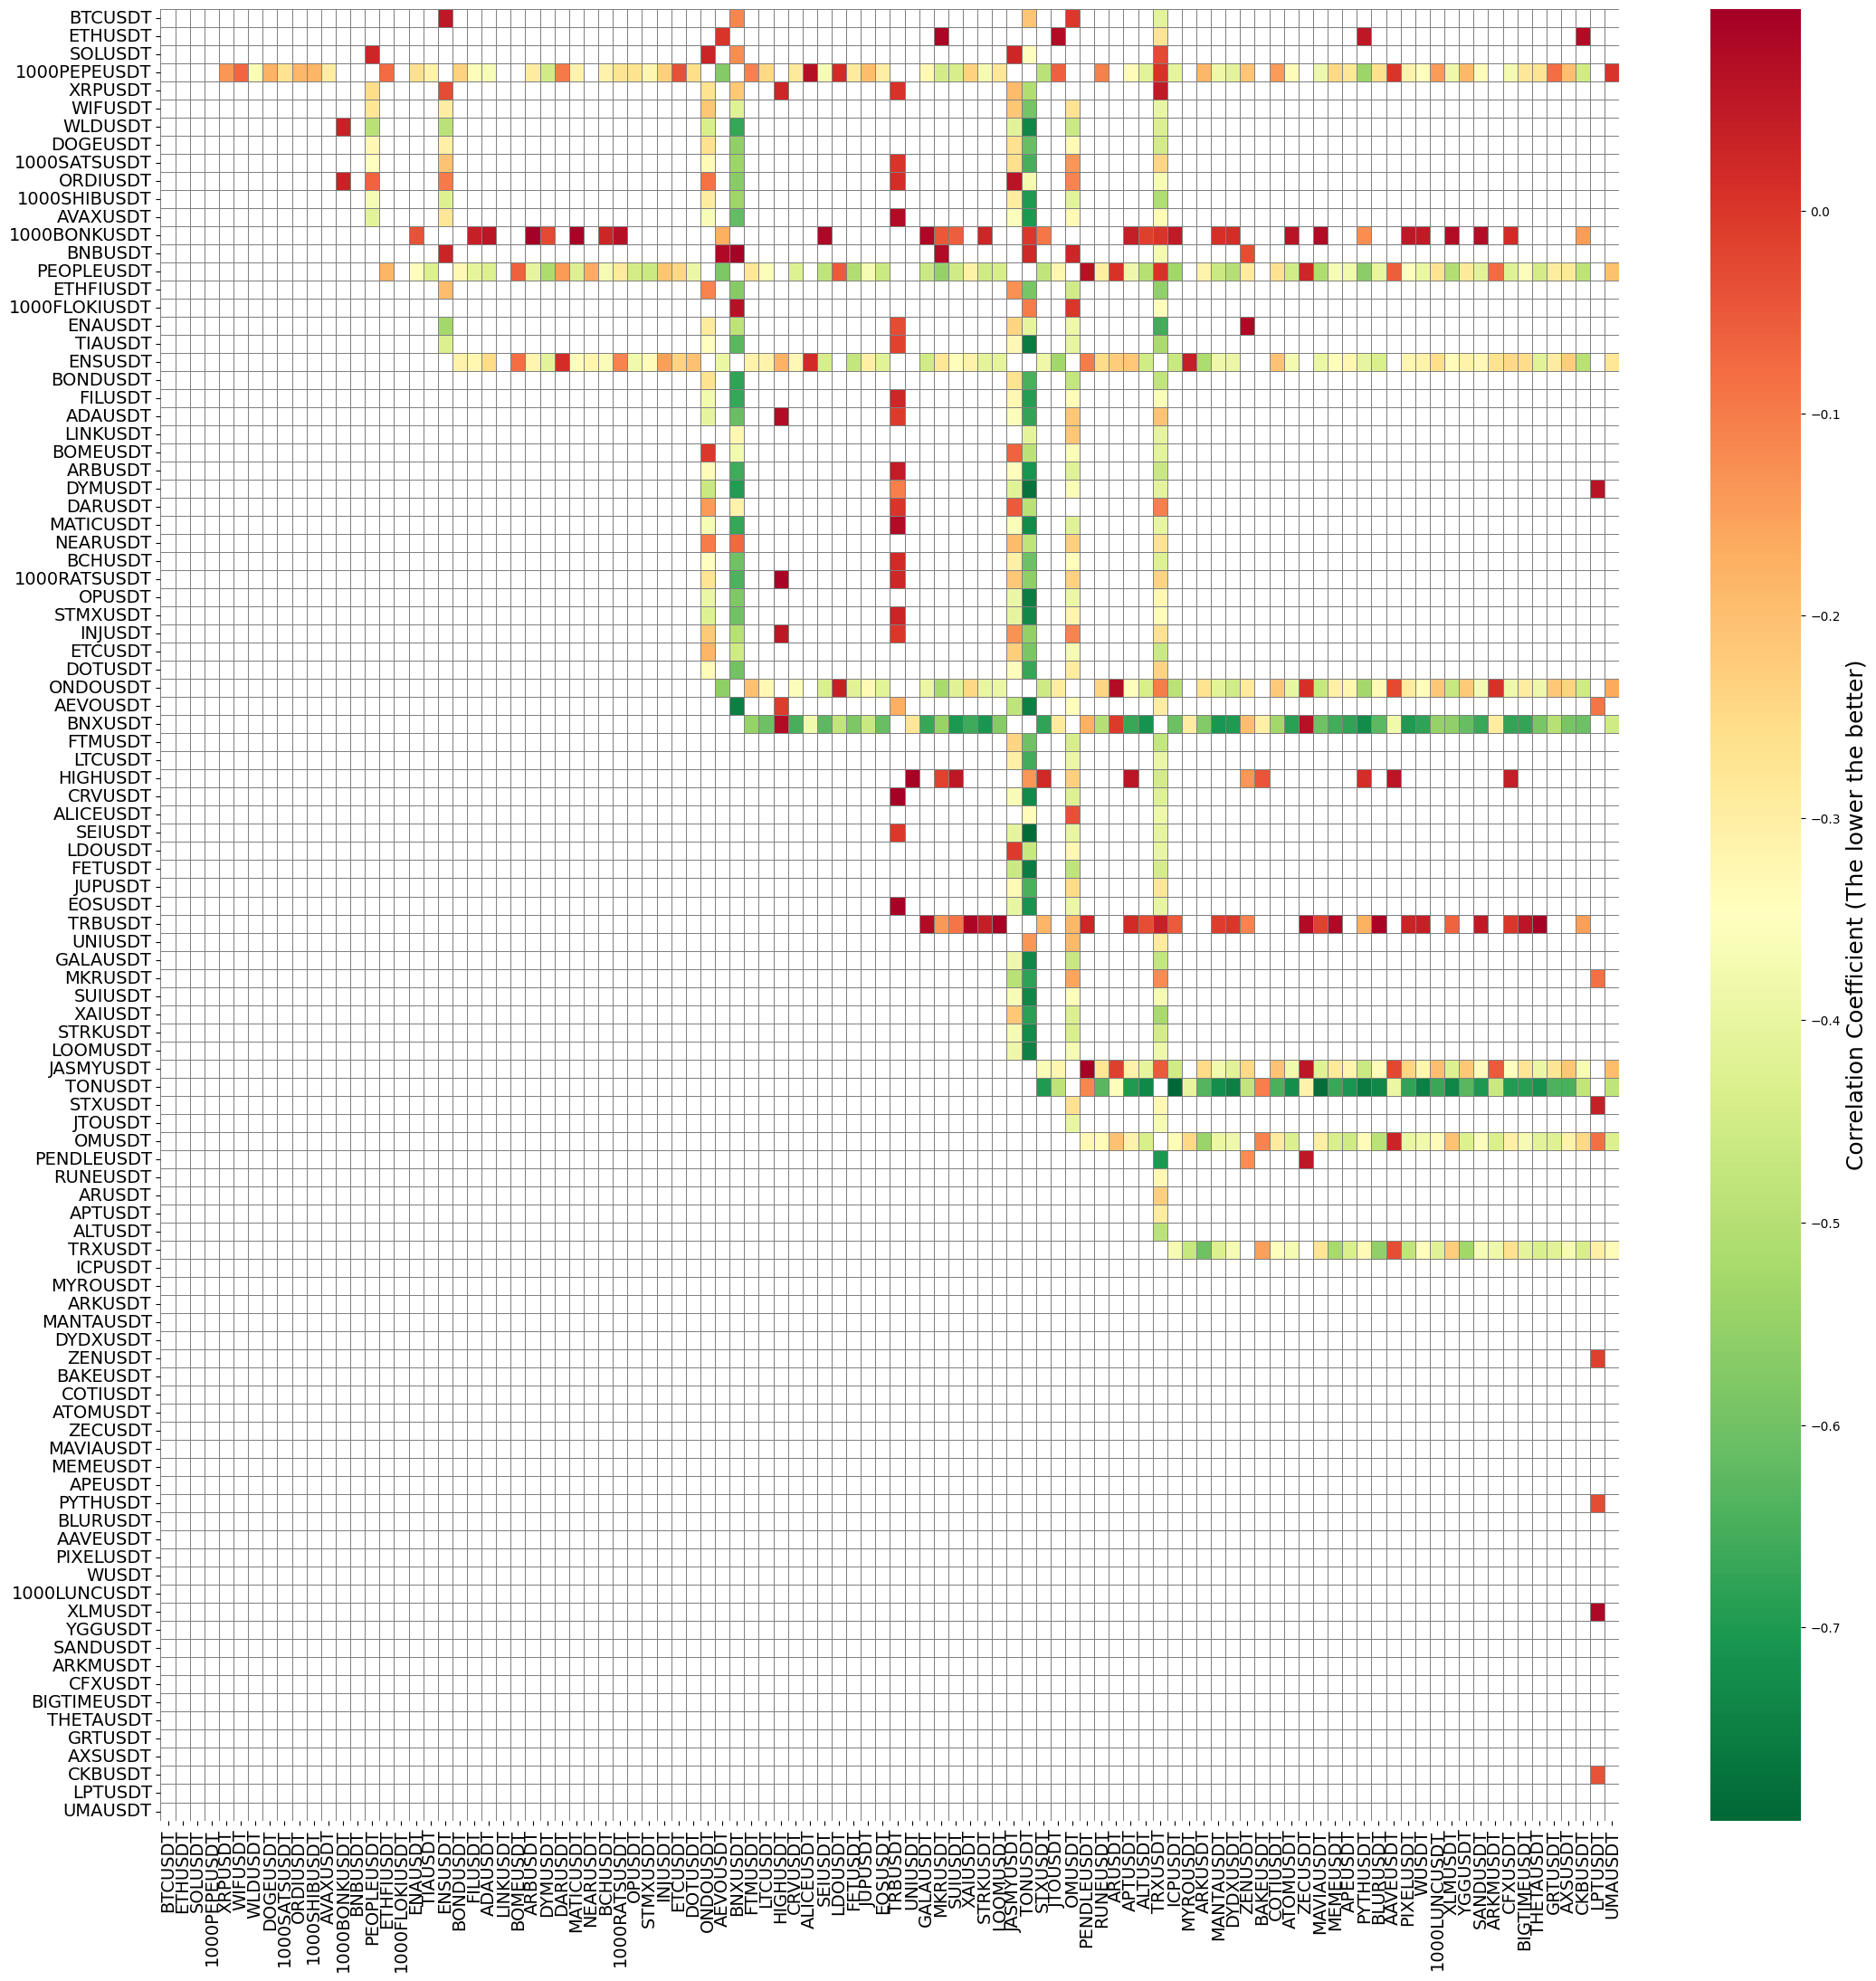

In [44]:
print("\n")

plt.figure(figsize=(26, 26))
heatmap = sns.heatmap(corrcoef_values, xticklabels=data_sanitized.keys(),
                      yticklabels=data_sanitized.keys(), cmap='RdYlGn_r',
                      mask=(corrcoef_values > (CORRCOEF_VALUE_THRESHOLD)),
                      linecolor='gray', linewidths=0.5)
heatmap.set_xticklabels(heatmap.get_xticklabels(), size=14)
heatmap.set_yticklabels(heatmap.get_yticklabels(), size=14)

colorbar = heatmap.collections[0].colorbar
colorbar.set_label('Correlation Coefficient (The lower the better)', size=18)

plt.show()

print("\n")

## Select Pairs for Detailed Analysis

- Please select any pair combination from the output below.

In [11]:
print("\nSelectable pairs:")

for pair in sorted_available_pairs:
    print("- {}".format(pair))

print("\n")


Selectable pairs:
- 1000BONKUSDT
- 1000FLOKIUSDT
- 1000LUNCUSDT
- 1000PEPEUSDT
- 1000RATSUSDT
- 1000SATSUSDT
- 1000SHIBUSDT
- AAVEUSDT
- ADAUSDT
- ALICEUSDT
- ALTUSDT
- APEUSDT
- APTUSDT
- ARBUSDT
- ARKMUSDT
- ARKUSDT
- ARUSDT
- ATOMUSDT
- AVAXUSDT
- AXSUSDT
- BAKEUSDT
- BCHUSDT
- BIGTIMEUSDT
- BLURUSDT
- BNBUSDT
- BNXUSDT
- BONDUSDT
- BTCUSDT
- CFXUSDT
- CHRUSDT
- CKBUSDT
- COTIUSDT
- CRVUSDT
- DARUSDT
- DOGEUSDT
- DOTUSDT
- DYDXUSDT
- DYMUSDT
- ENSUSDT
- EOSUSDT
- ETCUSDT
- ETHUSDT
- FETUSDT
- FILUSDT
- FTMUSDT
- GALAUSDT
- GMXUSDT
- GRTUSDT
- HBARUSDT
- HIFIUSDT
- HIGHUSDT
- ICPUSDT
- IMXUSDT
- INJUSDT
- JASMYUSDT
- JTOUSDT
- JUPUSDT
- LDOUSDT
- LINKUSDT
- LOOMUSDT
- LPTUSDT
- LTCUSDT
- MANAUSDT
- MANTAUSDT
- MATICUSDT
- MEMEUSDT
- MKRUSDT
- NEARUSDT
- ONDOUSDT
- OPUSDT
- ORDIUSDT
- PENDLEUSDT
- PEOPLEUSDT
- POLYXUSDT
- POWRUSDT
- PYTHUSDT
- RUNEUSDT
- SANDUSDT
- SEIUSDT
- SOLUSDT
- STMXUSDT
- STXUSDT
- SUIUSDT
- THETAUSDT
- TIAUSDT
- TRBUSDT
- TRUUSDT
- TRXUSDT
- UMAUSDT
- UNIUSDT

### Inputs

In [35]:
##### INPUTS #####
ticker_pairs = [("ALTUSDT", "BAKEUSDT")]
##################

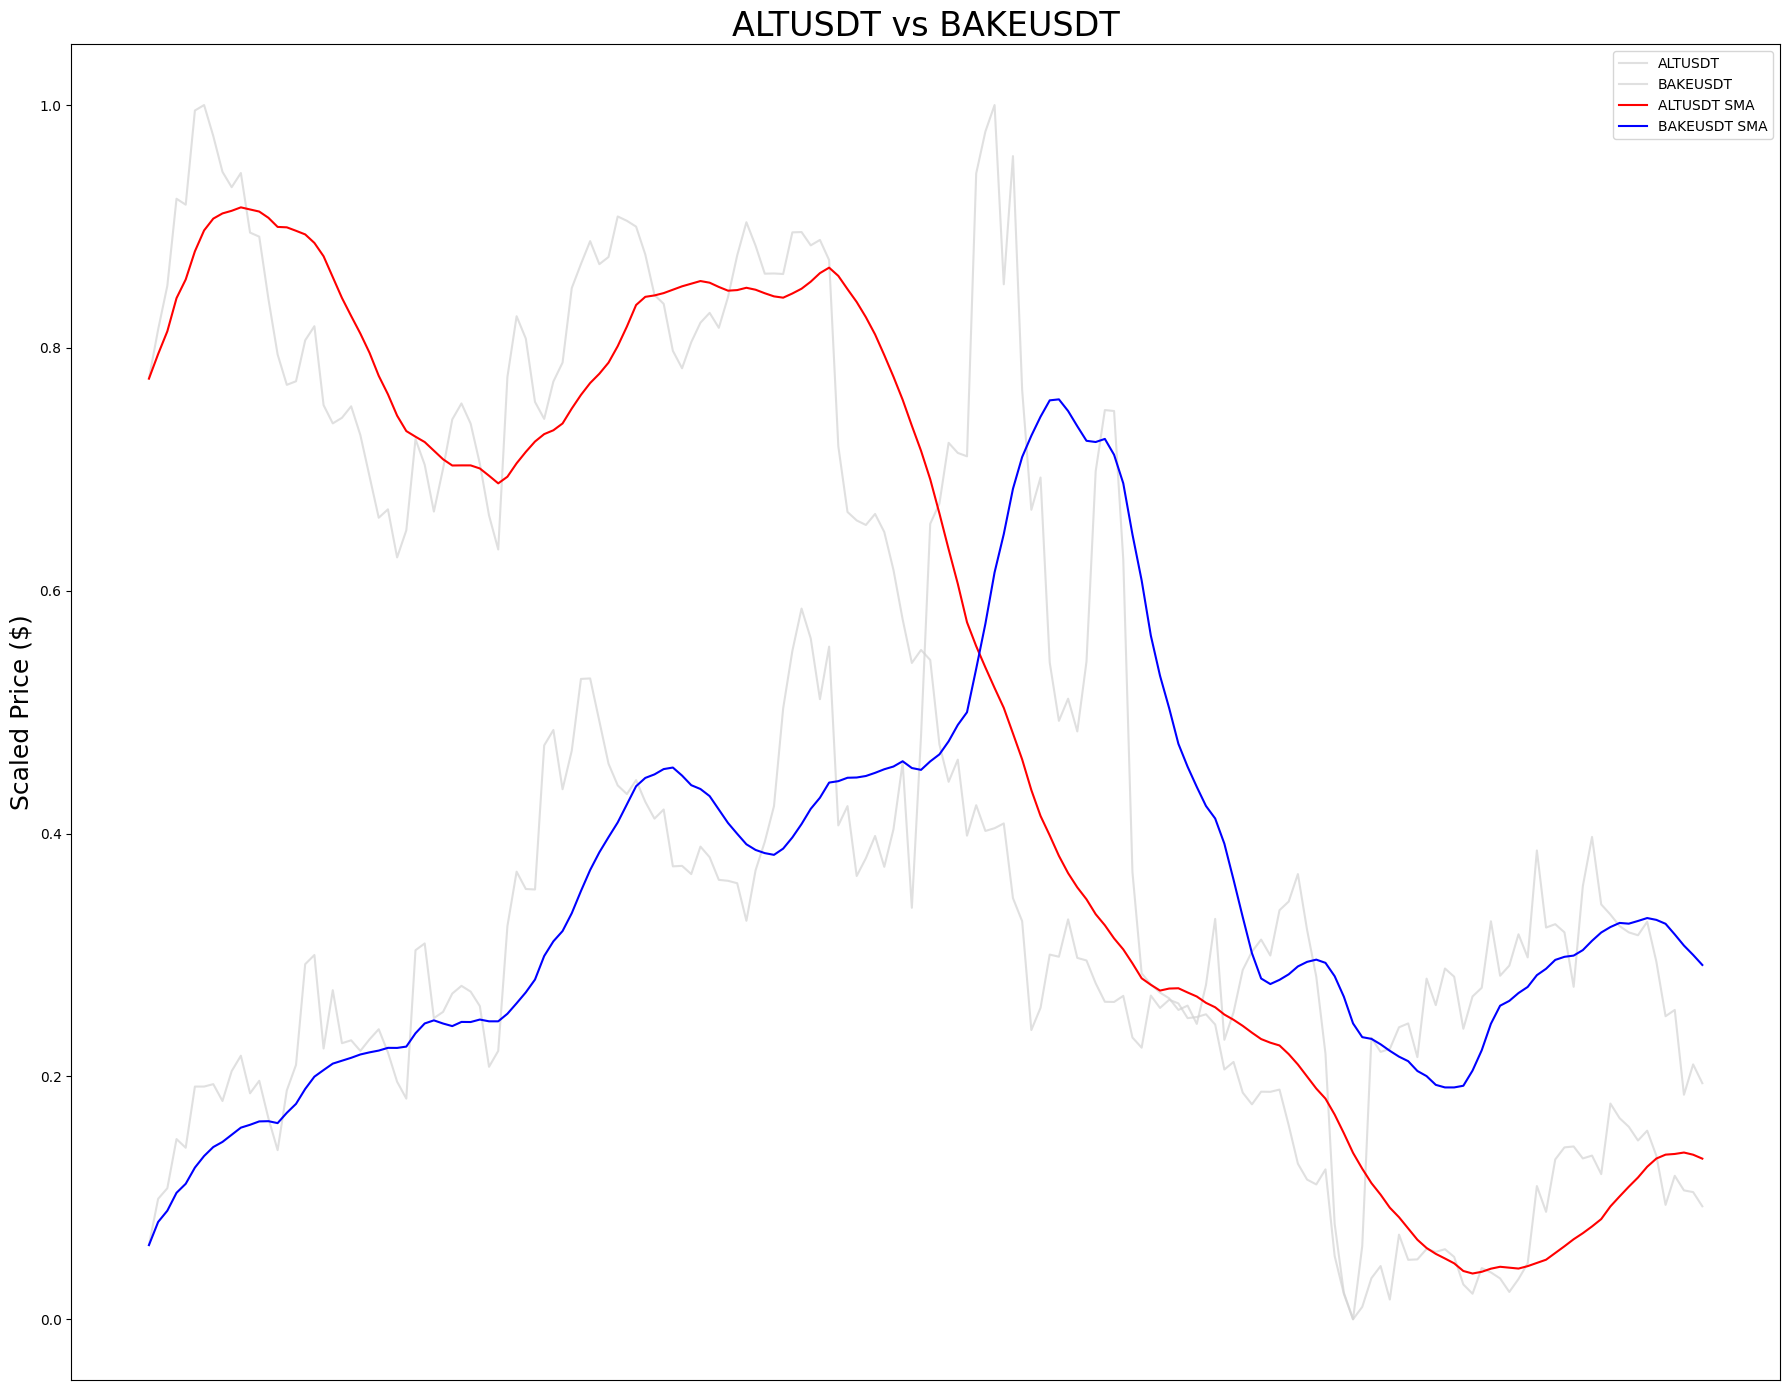

In [36]:
print("\n")

fig, axs = plt.subplots(len(ticker_pairs), 1, figsize=(18, 14))
if len(ticker_pairs) == 1:
    axs = [axs]
scaler = MinMaxScaler()

for i, (ticker1, ticker2) in enumerate(ticker_pairs):

    if ticker1 not in sorted_available_pairs:
        print("{} is not found in the list of selectable pairs. Please choose another one.".format(ticker1))
        if ticker2 not in sorted_available_pairs:
            print("{} is not found in the list of selectable pairs. Please choose another one.\n".format(ticker2))
        continue
        
    if ticker2 not in sorted_available_pairs:
        print("{} is not found in the list of selectable pairs. Please choose another one.".format(ticker2))
        if ticker1 not in sorted_available_pairs:
            print("{} is not found in the list of selectable pairs. Please choose another one.\n".format(ticker1))
        continue
    
    # Scale the price data for each pair using MIN MAX
    scaled_data1 = scaler.fit_transform(
        data_sanitized[ticker1]['Close'].values.reshape(-1, 1))
    scaled_data2 = scaler.fit_transform(
        data_sanitized[ticker2]['Close'].values.reshape(-1, 1))

    axs[i].plot(scaled_data1, label=f'{ticker1}', color='lightgray', alpha=0.7)
    axs[i].plot(scaled_data2, label=f'{ticker2}', color='lightgray', alpha=0.7)

    # Apply rolling mean with a window of 15
    scaled_data1_smooth = pd.Series(scaled_data1.flatten()).rolling(
        window=15, min_periods=1).mean()
    scaled_data2_smooth = pd.Series(scaled_data2.flatten()).rolling(
        window=15, min_periods=1).mean()

    axs[i].plot(scaled_data1_smooth, label=f'{ticker1} SMA', color='red')
    axs[i].plot(scaled_data2_smooth, label=f'{ticker2} SMA', color='blue')

    axs[i].set_ylabel('Scaled Price ($)', fontsize=18)
    axs[i].set_title(f'{ticker1} vs {ticker2}', fontsize=24)
    axs[i].legend()
    axs[i].set_xticks([])

plt.tight_layout()
plt.show()

print("\n")